# Calculate phase dependent modulation of AP generation in response to spatially diffuse or concentrated poisson excitation and rhythmic inhibition

The simulations had either: 
1. Rhythmic inhibition at the soma (64 Hz) or dendrites (16 Hz) 
2. Diffuse or concentrated synaptic excitation at and dendrites

Here we calculate the cross-correlation between action potentials and input on spatially diffuse or concentrated synapses. These are stratified by:
1. Phase (peak or trough) of the inhibitory rhythm
2. Frequency of rhythm

The output of this script are...


In [1]:
import sys
import os
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.linear_model import LogisticRegression
from src.cc_presyn_phdep_files import cc_presyn_phdep_files
from src.load_spike_h5 import load_spike_h5
from src.load_spike_aux_h5 import load_spike_aux_h5
from src.cc_ptpt import cc_ptpt

### 1.1 Simulation constants and analysis windows

In [36]:
samps_per_ms = 10 # samples per millisecond
fs = 10000 # sampling frequency
sim_win = [0, 9000000] # beginning and start points of simulation in samples
cc_bin = samps_per_ms * 1 # bin size for cross-correlation in samples
cc_win = [-499, 500] # number of lags for cross-correlation 

### 1.2 List files to be processed

In [37]:
# locate simulation files
dir_list = [{'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_conc_apical\\3groups',
             'InhibType': '16', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_conc_basal\\3groups',
             'InhibType': '16', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_diff\\long',
                'InhibType': '16', 'ExcType': 'diff', 'ExcLoc': 'apical'},
            #{'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_lessdiffuse_apical\\long',
            #    'InhibType': '16', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_conc_apical\\3groups',
                'InhibType': '64', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_conc_basal\\3groups',
                'InhibType': '64', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_diff\\long',
                'InhibType': '64', 'ExcType': 'diff', 'ExcLoc': 'apical'},
            #{'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_lessdiffuse_apical\\long',
            #    'InhibType': '64', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_conc_apical\\3groups',
                'InhibType': 'poiss', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_conc_basal\\3groups',
                'InhibType': 'poiss', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_diff\\long',
                'InhibType': 'poiss', 'ExcType': 'diff', 'ExcLoc': 'apical'},]
            #{'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_lessdiffuse_apical\\long',
            #    'InhibType': 'poiss', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'}]

sim_df = pd.DataFrame(dir_list)

### 1.3 Generate inhibitory rhythm time series

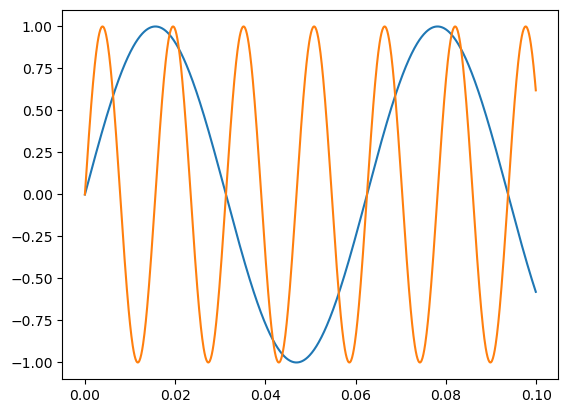

In [38]:
# generate phase time series for inhibitory afferents
t_ser = np.arange(sim_win[0], sim_win[1], 1) / fs # seconds
sin_16_ser = np.sin(t_ser*16*2*np.pi)
sin_64_ser = np.sin(t_ser*64*2*np.pi)

fig, ax = plt.subplots()
ax.plot(t_ser[0:1000],sin_16_ser[0:1000])
ax.plot(t_ser[0:1000],sin_64_ser[0:1000])
plt.show()

## 2.0 Phase startified cross-correlation between presynaptic spikes and action potentials

### 2.1 Calculate cross-correlations

In [39]:
def cc_func(sim_dir, inhib_type):
    # create full file path for presynaptic spike times and AP times, make OS independent
    presyn_file = os.path.join(sim_dir, 'exc_stim_aux_spikes2.h5')
    ap_file = os.path.join(sim_dir, 'spikes.h5')

    # calculate cross-correlation
    if inhib_type == '16':
        cc = cc_presyn_phdep_files(presyn_file, ap_file, sin_16_ser, cc_bin, cc_win, sm_win=1, notch_freq=16)
    elif inhib_type == '64':
        cc = cc_presyn_phdep_files(presyn_file, ap_file, sin_64_ser, cc_bin, cc_win, sm_win=1, notch_freq=64)
    elif inhib_type == 'poiss':
        spk_pts = load_spike_h5(ap_file)
        pre_pts = load_spike_aux_h5(presyn_file)
        cc = {'poiss': cc_ptpt(spk_pts, pre_pts, cc_bin, cc_win, 1)}
    return cc
    
# calculate cross-correlation for each simulation
sim_cc_df = sim_df.assign(AllCC = sim_df.apply(lambda x: cc_func(x['RootDir'], x['InhibType']), axis=1))

In [40]:
# breakout CC dictionaries
sim_cc_df = sim_cc_df.join(pd.DataFrame(sim_cc_df['AllCC'].tolist()))
sim_cc_df = pd.melt(sim_cc_df, id_vars=['RootDir', 'InhibType', 'ExcType', 'ExcLoc'],
                 value_vars=['t', 'p', 'poiss'], var_name='InhibPhase', value_name='CC')
sim_cc_df = sim_cc_df.dropna()
sim_cc_df = sim_cc_df.reset_index(drop=True)
sim_cc_df = sim_cc_df.join(pd.DataFrame(sim_cc_df['CC'].tolist()))
sim_cc_df.drop('CC', axis=1)

# smooth cross-correlations
def sm_func(x):
    sm_kern = np.hamming(3)
    x_sm = np.convolve(x, sm_kern/np.sum(sm_kern), mode='same')
    x_sm -= np.mean(x_sm)
    return x_sm

# smooth values_corr in sim_cc_df
sim_cc_df['values_corr_sm'] = sim_cc_df['values_corr'].apply(sm_func)

In [41]:
# group by excitatory input type
exc_df = sim_cc_df.groupby(['ExcType', 'ExcLoc'])

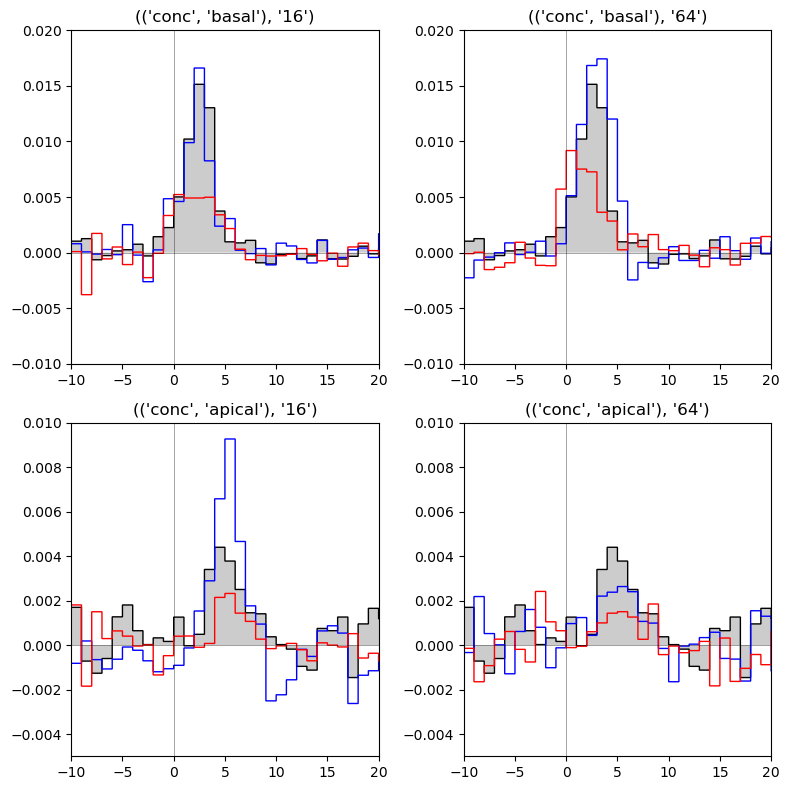

In [44]:
# plot corrected cross-correlations by excitatory input type
def plot_cc(sim_row, ax, **kwargs):
    ax.stairs(sim_row['values_corr_sm'].iloc[0][0:-1], sim_row['lags'].iloc[0], **kwargs)

def plot_exp(sim_set, exp_name, exp_freq, ax):
    plot_cc(sim_set[sim_set['InhibPhase']=='poiss'],ax, color=[0.8]*3, fill=True)
    plot_cc(sim_set[sim_set['InhibPhase']=='poiss'],ax, color='k')
    plot_cc(sim_set.loc[(sim_set['InhibPhase']=='t') & (sim_set['InhibType']==exp_freq)],ax, color='b')
    plot_cc(sim_set.loc[(sim_set['InhibPhase']=='p') & (sim_set['InhibType']==exp_freq)],ax, color='r')
    
    ax.set_title((exp_name, exp_freq))
    #ax.set_ylim(-0.01,0.015)
    ax.set_xlim(-10,20)
    # create grid only on origin
    ax.vlines(0, -0.01, 0.02, color='k', linewidth=0.5, alpha=0.5)
    ax.hlines(0, -10, 20, color='k', linewidth=0.5, alpha=0.5)


fig,ax = plt.subplots(2,2)
plot_exp(exc_df.get_group(('conc', 'basal')), ('conc', 'basal'), '16',ax[0,0])
ax[0,0].set_ylim(-0.01,0.02)
plot_exp(exc_df.get_group(('conc', 'basal')), ('conc', 'basal'), '64',ax[0,1])
ax[0,1].set_ylim(-0.01,0.02)
plot_exp(exc_df.get_group(('conc', 'apical')), ('conc', 'apical'), '16',ax[1,0])
ax[1,0].set_ylim(-0.005,0.01)
plot_exp(exc_df.get_group(('conc', 'apical')), ('conc', 'apical'), '64',ax[1,1])
ax[1,1].set_ylim(-0.005,0.01)
fig.set_size_inches(8, 8)
fig.tight_layout()
fig.savefig('../figures/PhaseModNMDAAPCC.pdf')


In [45]:
# define a function to calculate the area under a curve bordered by zero-crossings
# that encompasses a user specified position
def area_under_curve(x, ind):
    # find the zero-crossing before the index
    ind0 = np.where(np.diff(np.sign(x[0:ind])))[0]
    if len(ind0) == 0:
        ind0 = 0
    else:
        ind0 = ind0[-1]

    # find the zero-crossing after the index
    ind1 = np.where(np.diff(np.sign(x[ind:-1])))[0]

    if len(ind1) == 0:
        ind1 = len(x)
    else:
        ind1 = ind1[0] + ind
    
    # calculate the area under the curve
    area = np.trapz(x[ind0:ind1])

    return area

# identify the index overlapping with the cross-correlation peak
ind_peak = (-cc_win[0])+5


# calculate the area under the curve for each simulation
sim_cc_df['resp_area'] = sim_cc_df['values_corr_sm'].apply(lambda x: area_under_curve(x, ind_peak))

In [53]:
exc_df = sim_cc_df.groupby(['ExcType', 'ExcLoc'])[['resp_area', 'InhibType', 'InhibPhase']]
exc_df.get_group(('conc', 'basal'))

,resp_area,InhibType,InhibPhase
1,0.047066,16,t
4,0.057582,64,t
7,0.027835,16,p
10,0.040016,64,p
13,0.052098,poiss,poiss


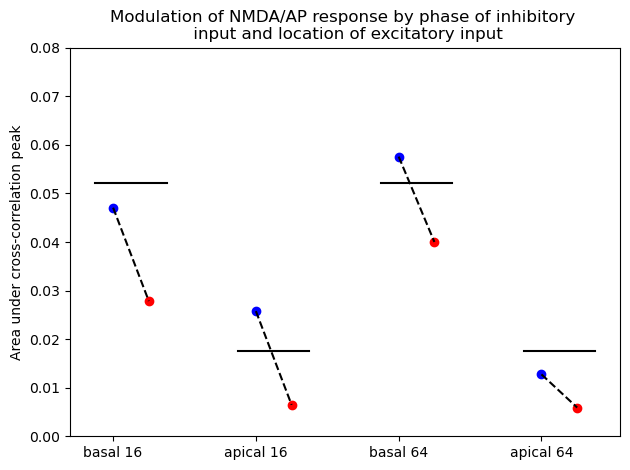

In [66]:
# group by excitatory input type

# plot cross-correlation strengths by excitatory input type and phase
def plot_exp_resp(sim_set, exp_freq, offset, ax):
    offset = offset*4
    poiss_resp = sim_set.loc[(sim_set['InhibPhase']=='poiss')]['resp_area'].iloc[0]
    t_resp = sim_set.loc[(sim_set['InhibPhase']=='t') & (sim_set['InhibType']==exp_freq)]['resp_area'].iloc[0]
    p_resp = sim_set.loc[(sim_set['InhibPhase']=='p') & (sim_set['InhibType']==exp_freq)]['resp_area'].iloc[0]

    ax.plot(offset+np.array([0.5,2.5]), [poiss_resp, poiss_resp], color='k')
    #ax.scatter(offset, poiss_resp, color='k')
    ax.plot(offset+np.array([1,2]), [t_resp, p_resp], color='k', linestyle='--')
    ax.scatter(offset+1, t_resp, color='b')
    ax.scatter(offset+2, p_resp, color='r')


fig,ax = plt.subplots()
plot_exp_resp(exc_df.get_group(('conc', 'basal')), '16', 0, ax)
plot_exp_resp(exc_df.get_group(('conc', 'apical')), '16', 1, ax)
plot_exp_resp(exc_df.get_group(('conc', 'basal')), '64', 2, ax)
plot_exp_resp(exc_df.get_group(('conc', 'apical')), '64', 3, ax)
ax.set_ylim([0,0.08])
ax.set_xticks([1,5,9,13])
ax.set_xticklabels(['basal 16', 'apical 16', 'basal 64', 'apical 64'])
ax.set_ylabel('Area under cross-correlation peak')
ax.set_title('Modulation of NMDA/AP response by phase of inhibitory \n input and location of excitatory input')
fig.tight_layout()
fig.savefig('../figures/PhaseModNMDAAPCC_Resp.pdf')